# Airbnb - Machine Learning Project
***
Chicago Listings & Reviews - 09/2019
<br/>
http://insideairbnb.com/get-the-data.html

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import xgboost as xgb

## Initial General Cleaning

In [2]:
raw_df = pd.read_csv('data/list_gz.csv', low_memory = False)

print(raw_df.info())

pd.set_option('display.max_columns', len(raw_df.columns))
raw_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8852 entries, 0 to 8851
Columns: 106 entries, id to reviews_per_month
dtypes: float64(21), int64(23), object(62)
memory usage: 7.2+ MB
None


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20190922191701,2019-09-22,Hyde Park Private Room - Pleasant Walk to UChi...,You are invited to be the sole Airbnb guest in...,"The private bedroom has a queen size bed, beds...",You are invited to be the sole Airbnb guest in...,none,My apartment is one block from beautiful Jacks...,The basement laundry room hours are 8:00am to ...,UNIVERSITY OF CHICAGO: Visiting academics and ...,You will have access to the entire apartment -...,I will greet you when you arrive and show you ...,1. Your booking is for ONE (1) guest only - th...,NaN,NaN,https://a0.muscache.com/im/pictures/acf6b3c0-4...,NaN,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1,1,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Chicago, IL, United States",Hyde Park,Hyde Park,NaN,Chicago,IL,60637,Chicago,"Chicago, IL",US,United States,41.78886,-87.58671,t,Condominium,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",NaN,$50.00,$350.00,NaN,$0.00,$20.00,1,$0.00,2,91,2,2,91,91,2.0,91.0,3 weeks ago,t,2,28,55,330,2019-09-22,170,38,2015-01-09,2019-09-16,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{""Illinois State"","" Cook County"","" IL"","" CHICA...",t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.97
1,4505,https://www.airbnb.com/rooms/4505,20190922191701,2019-09-22,One Great Apartment. 377 Great Reviews. 1 Bad ...,"We took the winter off, made things nicer arou...","We travel a lot, we know what people need. We...","We took the winter off, made things nicer arou...",none,NaN,NaN,The CTA train station is 30 yards (27 meters) ...,We also have a huge yard. Use it (weather perm...,NaN,Don't sit around all day watching T.V. Don't h...,NaN,NaN,https://a0.muscache.com/im/pictures/15019798/7...,NaN,5775,https://www.airbnb.com/users/show/5775,Craig & Kathleen,2008-12-29,"Chicago, Illinois, United States",Incredibly creative(Kathleen) and stunningly a...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/5775/profile_...,https://a0.muscache.com/im/use

# Preemptively Comparing Price, Space, and Location

Near North Side            22
South Loop/Printers Row    20
Lakeview                   18
Logan Square               13
River West                 13
River North                12
Wicker Park                 9
Streeterville               7
Uptown                      6
Lincoln Park                6
Name: neighbourhood, dtype: int64

There are 165 neighborhood listings over $750. 1.9% of total.


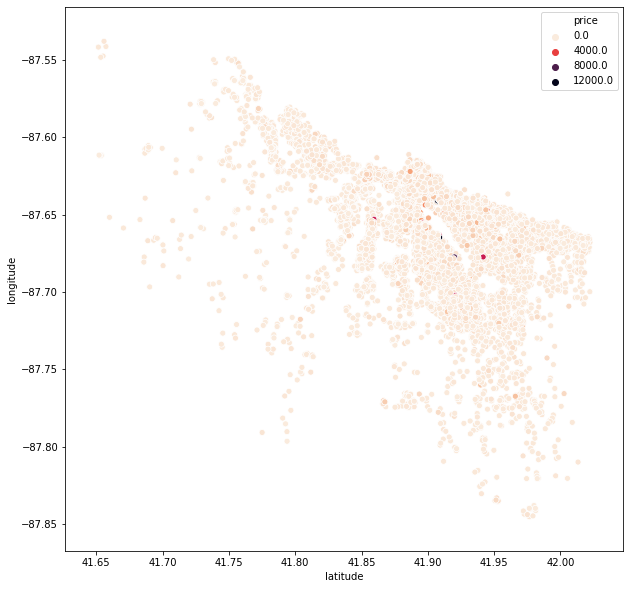

In [3]:
air_df = raw_df.copy()

temp = air_df.copy()
temp['price'] = temp['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

plt.figure(figsize=(10,10))
sns.scatterplot(x='latitude', y='longitude', hue='price', data = temp, palette = 'rocket_r'); 

temp = temp[temp.price > 750]
print(temp['neighbourhood'].value_counts()[:10])
x = temp['neighbourhood'].value_counts().sum()
print(f'\nThere are {x:,} neighborhood listings over $750. {x/len(air_df):.1%} of total.')

4357    10000.0
8155    10000.0
8099    10000.0
1600    10000.0
8100    10000.0
8153    10000.0
8154    10000.0
2770     9999.0
8162     8000.0
4366     6200.0
7110     5000.0
8310     5000.0
7544     5000.0
7543     5000.0
7112     5000.0
Name: price, dtype: float64

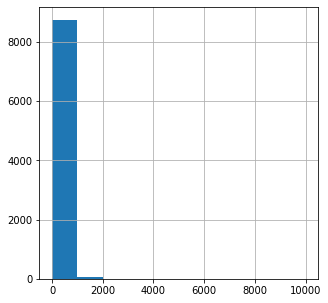

In [4]:
temp = air_df.copy()
temp['price'] = temp['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
temp['price'].hist(figsize=(5,5));

temp['price'].sort_values(ascending=False).head(15)

In [5]:
air_df['price'] = air_df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
air_df = air_df[air_df.price < 800]
print(air_df.info())
air_df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8692 entries, 0 to 8851
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(23), object(61)
memory usage: 7.1+ MB
None


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20190922191701,2019-09-22,Hyde Park Private Room - Pleasant Walk to UChi...,You are invited to be the sole Airbnb guest in...,"The private bedroom has a queen size bed, beds...",You are invited to be the sole Airbnb guest in...,none,My apartment is one block from beautiful Jacks...,The basement laundry room hours are 8:00am to ...,UNIVERSITY OF CHICAGO: Visiting academics and ...,You will have access to the entire apartment -...,I will greet you when you arrive and show you ...,1. Your booking is for ONE (1) guest only - th...,NaN,NaN,https://a0.muscache.com/im/pictures/acf6b3c0-4...,NaN,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1,1,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Chicago, IL, United States",Hyde Park,Hyde Park,NaN,Chicago,IL,60637,Chicago,"Chicago, IL",US,United States,41.78886,-87.58671,t,Condominium,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",NaN,50.0,$350.00,NaN,$0.00,$20.00,1,$0.00,2,91,2,2,91,91,2.0,91.0,3 weeks ago,t,2,28,55,330,2019-09-22,170,38,2015-01-09,2019-09-16,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{""Illinois State"","" Cook County"","" IL"","" CHICA...",t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.97
1,4505,https://www.airbnb.com/rooms/4505,20190922191701,2019-09-22,One Great Apartment. 377 Great Reviews. 1 Bad ...,"We took the winter off, made things nicer arou...","We travel a lot, we know what people need. We...","We took the winter off, made things nicer arou...",none,NaN,NaN,The CTA train station is 30 yards (27 meters) ...,We also have a huge yard. Use it (weather perm...,NaN,Don't sit around all day watching T.V. Don't h...,NaN,NaN,https://a0.muscache.com/im/pictures/15019798/7...,NaN,5775,https://www.airbnb.com/users/show/5775,Craig & Kathleen,2008-12-29,"Chicago, Illinois, United States",Incredibly creative(Kathleen) and stunningly a...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/5775/profile_...,https://a0.muscache.com/im/users

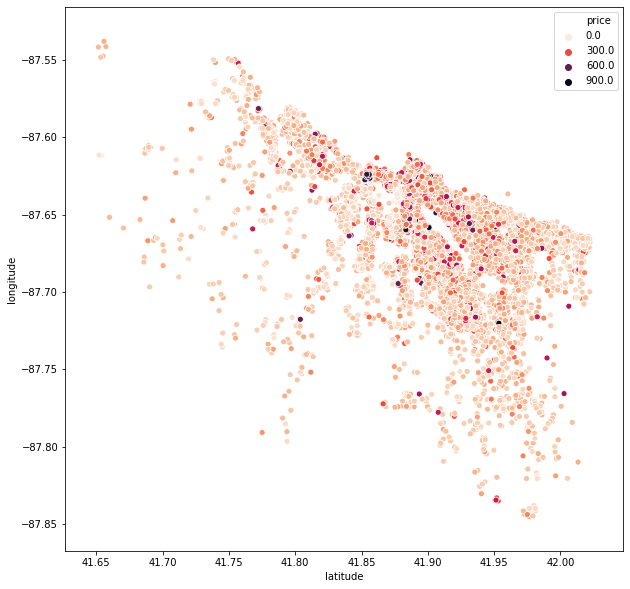

In [6]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='latitude', y='longitude', hue='price', data = air_df, palette = 'rocket_r'); 

del temp, x

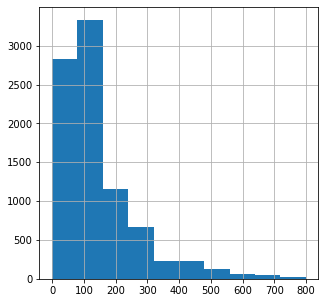

In [7]:
air_df['price'].hist(figsize=(5,5));

#### Dropping Null Values

In [8]:
print(air_df['experiences_offered'].value_counts())

temp = air_df.isna().sum().sort_values(ascending = False)
temp = pd.DataFrame(temp).reset_index()

temp.head(10)

none    8692
Name: experiences_offered, dtype: int64


,index,0
0,neighbourhood_group_cleansed,8692
1,host_acceptance_rate,8692
2,xl_picture_url,8692
3,medium_url,8692
4,thumbnail_url,8692
5,square_feet,8623
6,monthly_price,8128
7,weekly_price,8100
8,notes,3731
9,access,2906


In [9]:
temp = temp[temp[0] > len(air_df)/2]
temp = temp['index'].tolist()

temp

['neighbourhood_group_cleansed',
 'host_acceptance_rate',
 'xl_picture_url',
 'medium_url',
 'thumbnail_url',
 'square_feet',
 'monthly_price',
 'weekly_price']

In [10]:
air_df.drop(temp, axis=1, inplace=True)

del temp 

air_df.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20190922191701,2019-09-22,Hyde Park Private Room - Pleasant Walk to UChi...,You are invited to be the sole Airbnb guest in...,"The private bedroom has a queen size bed, beds...",You are invited to be the sole Airbnb guest in...,none,My apartment is one block from beautiful Jacks...,The basement laundry room hours are 8:00am to ...,UNIVERSITY OF CHICAGO: Visiting academics and ...,You will have access to the entire apartment -...,I will greet you when you arrive and show you ...,1. Your booking is for ONE (1) guest only - th...,https://a0.muscache.com/im/pictures/acf6b3c0-4...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,100%,t,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1,1,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Chicago, IL, United States",Hyde Park,Hyde Park,Chicago,IL,60637,Chicago,"Chicago, IL",US,United States,41.78886,-87.58671,t,Condominium,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,$0.00,$20.00,1,$0.00,2,91,2,2,91,91,2.0,91.0,3 weeks ago,t,2,28,55,330,2019-09-22,170,38,2015-01-09,2019-09-16,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{""Illinois State"","" Cook County"","" IL"","" CHICA...",t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.97
1,4505,https://www.airbnb.com/rooms/4505,20190922191701,2019-09-22,One Great Apartment. 377 Great Reviews. 1 Bad ...,"We took the winter off, made things nicer arou...","We travel a lot, we know what people need. We...","We took the winter off, made things nicer arou...",none,NaN,NaN,The CTA train station is 30 yards (27 meters) ...,We also have a huge yard. Use it (weather perm...,NaN,Don't sit around all day watching T.V. Don't h...,https://a0.muscache.com/im/pictures/15019798/7...,5775,https://www.airbnb.com/users/show/5775,Craig & Kathleen,2008-12-29,"Chicago, Illinois, United States",Incredibly creative(Kathleen) and stunningly a...,within a few hours,100%,t,https://a0.muscache.com/im/users/5775/profile_...,https://a0.muscache.com/im/users/5775/profile_...,Little Village,1,1,"['email', 'phone', 'reviews', 'kba']",t,t,"Chicago, IL, United States",Little Village,South Lawndale,Chicago,IL,60608,Chicago,"Chicago, IL",US,

#### Converting Strings into Floats and Changing T/F Response Values

In [11]:
temp = ['security_deposit', 
        'cleaning_fee', 
        'extra_people' 
       ]

for col in temp:
    air_df[col] = air_df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)
    air_df[col].fillna(0,inplace=True)
    
del temp    

air_df['price'].head()

0     50.0
1    117.0
2     80.0
3    150.0
4    215.0
Name: price, dtype: float64

In [12]:
air_df.replace({'f': 0, 't': 1}, inplace=True)

air_df['instant_bookable'].head(2)

0    1
1    1
Name: instant_bookable, dtype: int64

#### Separating Column Names by Type

In [13]:
temp = air_df.dtypes.apply(lambda x: x.name).to_dict()

dict(list(temp.items())[:5])

{'id': 'int64',
 'listing_url': 'object',
 'scrape_id': 'int64',
 'last_scraped': 'object',
 'name': 'object'}

In [14]:
str_col = []

for key, val in temp.items():
    if val == 'object': 
        str_col.append(key)
    else:
        pass

del temp

print(f'{len(str_col)} string columns')
str_col

46 string columns


['listing_url',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_verifications',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'property_type',
 'room_type',
 'bed_type',
 'amenities',
 'calendar_updated',
 'calendar_last_scraped',
 'first_review',
 'last_review',
 'license',
 'jurisdiction_names',
 'cancellation_policy']

In [15]:
temp = ['neighbourhood', 
        'neighbourhood_cleansed', 
        'property_type', 
        'room_type', 
        'bed_type', 
        'amenities'
       ]

temp = list(set(str_col) - set(temp))

print(f'{len(temp)} string columns')
temp

40 string columns


['host_name',
 'calendar_updated',
 'host_since',
 'listing_url',
 'country_code',
 'notes',
 'space',
 'host_about',
 'transit',
 'host_thumbnail_url',
 'city',
 'calendar_last_scraped',
 'summary',
 'street',
 'license',
 'host_neighbourhood',
 'picture_url',
 'host_response_rate',
 'smart_location',
 'country',
 'first_review',
 'market',
 'jurisdiction_names',
 'host_url',
 'state',
 'host_location',
 'house_rules',
 'interaction',
 'host_response_time',
 'last_scraped',
 'cancellation_policy',
 'neighborhood_overview',
 'name',
 'experiences_offered',
 'host_verifications',
 'last_review',
 'zipcode',
 'description',
 'access',
 'host_picture_url']

In [16]:
air_df.drop(temp, axis=1, inplace=True)
del str_col, temp

air_df.head(2)

,id,scrape_id,host_id,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,20190922191701,2613,1,1,1,1,1,Hyde Park,Hyde Park,41.78886,-87.58671,1,Condominium,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,0.0,20.0,1,0.0,2,91,2,2,91,91,2.0,91.0,1,2,28,55,330,170,38,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,0,0,1,0,1,0,2.97
1,4505,20190922191701,5775,1,1,1,1,1,Little Village,South Lawndale,41.85495,-87.69696,1,Apartment,Entire home/apt,7,1.0,3.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",117.0,0.0,35.0,2,25.0,2,60,2,2,60,60,2.0,60.0,1,19,43,73,348,383,22,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,0,0,1,1,0,0,2.98


#### Investigating Remaining String Columns Further

In [17]:
# https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago
# neighbourhood_cleaned seems to be community
# neighbourhood offers more variability and will be kept

air_df[['neighbourhood', 'neighbourhood_cleansed']].head(10)

,neighbourhood,neighbourhood_cleansed
0,Hyde Park,Hyde Park
1,Little Village,South Lawndale
2,Ukrainian Village,West Town
3,Old Town,Lincoln Park
4,Old Town,Lincoln Park
5,Lincoln Park,Lincoln Park
6,West Town/Noble Square,West Town
7,Old Town,Lincoln Park
8,Bucktown,Logan Square
9,Uptown,Uptown


In [18]:
temp = ['property_type', 
        'room_type', 
        'bed_type'
       ]

for x in temp:
    print(f'\n{x}:')
    print(air_df[x].value_counts())
    
del temp


property_type:
Apartment             5107
Condominium           1317
House                 1176
Townhouse              233
Loft                   232
Guest suite            184
Serviced apartment     159
Bungalow                73
Boutique hotel          71
Guesthouse              53
Bed and breakfast       19
Hostel                  16
Other                   10
Cottage                  7
Boat                     6
Hotel                    5
Tiny house               5
Aparthotel               4
Castle                   3
Resort                   3
Camper/RV                2
Barn                     2
Cave                     1
Villa                    1
Hut                      1
Campsite                 1
Farm stay                1
Name: property_type, dtype: int64

room_type:
Entire home/apt    5872
Private room       2480
Shared room         195
Hotel room          145
Name: room_type, dtype: int64

bed_type:
Real Bed         8594
Airbed             34
Futon              32
Pull-o

In [19]:
air_df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment', 
    }, inplace=True)

temp = ['Apartment', 
        'Condominium', 
        'House'
       ]

air_df['property_type'] = air_df['property_type'].apply(lambda x: x if x in temp else 'Other')
air_df['property_type'].value_counts()

Apartment      5266
House          1409
Condominium    1317
Other           700
Name: property_type, dtype: int64

In [20]:
temp = ['id', 
        'scrape_id', 
        'host_id', 
        'neighbourhood_cleansed', 
        'bed_type'
       ]

air_df.drop(temp, axis=1, inplace=True)
del temp

air_df.head(2)

,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1,1,1,1,1,Hyde Park,41.78886,-87.58671,1,Condominium,Private room,1,1.0,1.0,1.0,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,0.0,20.0,1,0.0,2,91,2,2,91,91,2.0,91.0,1,2,28,55,330,170,38,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,0,0,1,0,1,0,2.97
1,1,1,1,1,1,Little Village,41.85495,-87.69696,1,Apartment,Entire home/apt,7,1.0,3.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",117.0,0.0,35.0,2,25.0,2,60,2,2,60,60,2.0,60.0,1,19,43,73,348,383,22,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1,1,0,0,0,1,1,0,0,2.98


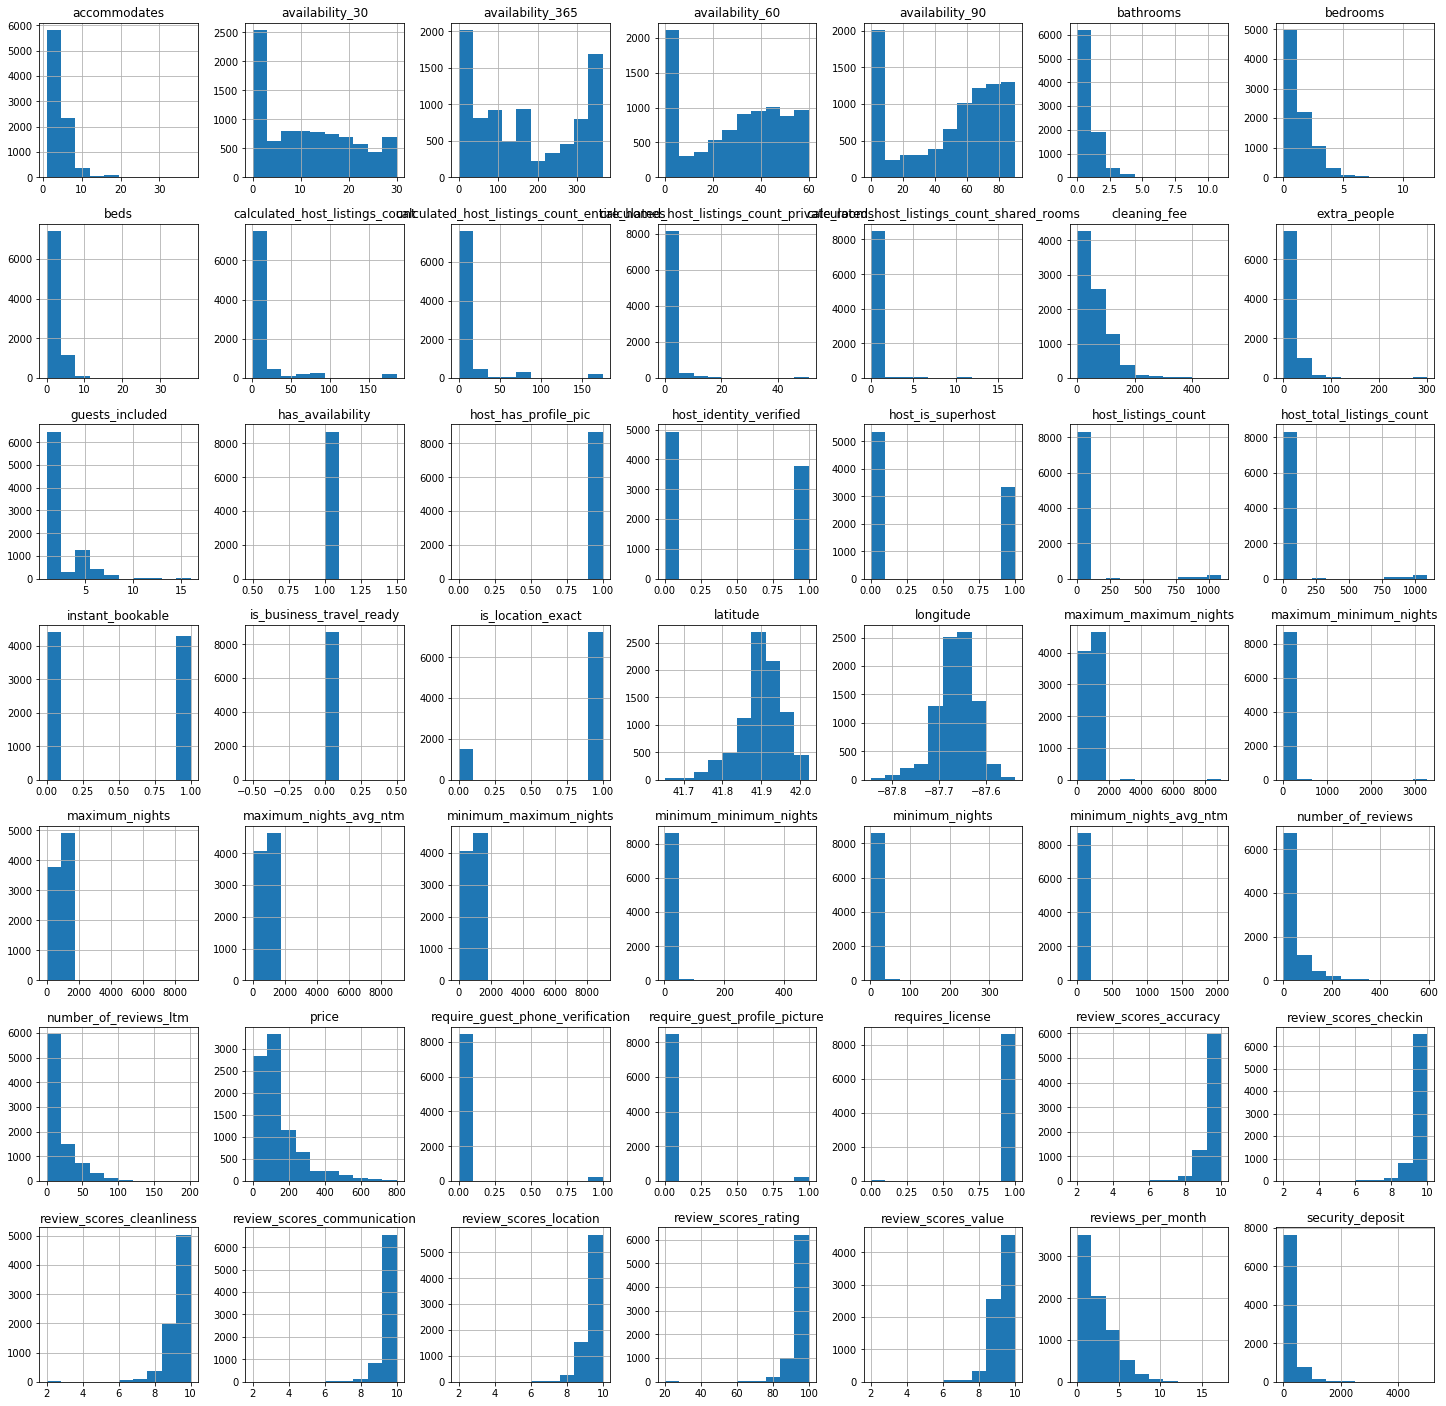

In [21]:
air_df.hist(figsize=(25,25));

In [22]:
# storing lat/long coordinates in case decide to use them later

lat_lng = air_df[['latitude','longitude']].copy()
lat_lng.head(2)

,latitude,longitude
0,41.78886,-87.58671
1,41.85495,-87.69696


In [23]:
# minimum_nights
# minimum_minimum_nights
# maximum_minimum_nights

# maximum_nights
# minimum_maximum_nights
# maximum_maximum_nights

# average nights
# minimum_nights_avg_ntm
# maximum_nights_avg_ntm

print(f' Min. diffs.: {sum((air_df.minimum_nights == air_df.minimum_minimum_nights) == False)}')
print(f' Max. diffs.: {sum((air_df.maximum_nights == air_df.maximum_maximum_nights) == False)}')

 Min. diffs.: 756
 Max. diffs.: 309


In [24]:
# 'host_total_listings_count', 
# 'calculated_host_listings_count', 
# 'calculated_host_listings_count_entire_homes', 
# 'calculated_host_listings_count_private_rooms', 
# 'calculated_host_listings_count_shared_rooms'

print(f'Tot.: {sum((air_df.host_listings_count == air_df.host_total_listings_count) == False)}')
# print(f'Calc.: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count) == False)}')
# print(f'Calc. Homes: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count_entire_homes) == False)}')
# print(f'Calc. Priv.: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count_private_rooms) == False)}')
# print(f'Calc. Shared: {sum((air_df.host_listings_count == air_df.calculated_host_listings_count_shared_rooms) == False)}')

Tot.: 0


Both the `host_listings_count` and `host_total_listings_count` have the same values. One will be dropped

In [25]:
temp = ['host_total_listings_count', 
        'host_total_listings_count', 
        'calculated_host_listings_count', 
        'calculated_host_listings_count_entire_homes', 
        'calculated_host_listings_count_private_rooms', 
        'calculated_host_listings_count_shared_rooms', 
        'minimum_minimum_nights', 
        'maximum_minimum_nights', 
        'minimum_maximum_nights', 
        'maximum_maximum_nights', 
        'minimum_nights_avg_ntm', 
        'maximum_nights_avg_ntm', 
        'is_location_exact', 
        'has_availability', 
        'host_has_profile_pic', 
        'is_business_travel_ready', 
        'require_guest_phone_verification', 
        'require_guest_profile_picture', 
        'requires_license', 
        'availability_30', 
        'availability_60', 
        'availability_90']

air_df.drop(temp, axis=1, inplace=True)
del temp

air_df.head(2)

,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,1,1,1,Hyde Park,41.78886,-87.58671,Condominium,Private room,1,1.0,1.0,1.0,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,0.0,20.0,1,0.0,2,91,330,170,38,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2.97
1,1,1,1,Little Village,41.85495,-87.69696,Apartment,Entire home/apt,7,1.0,3.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",117.0,0.0,35.0,2,25.0,2,60,348,383,22,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2.98


['host_is_superhost',
 'host_listings_count',
 'host_identity_verified',
 'neighbourhood',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month']


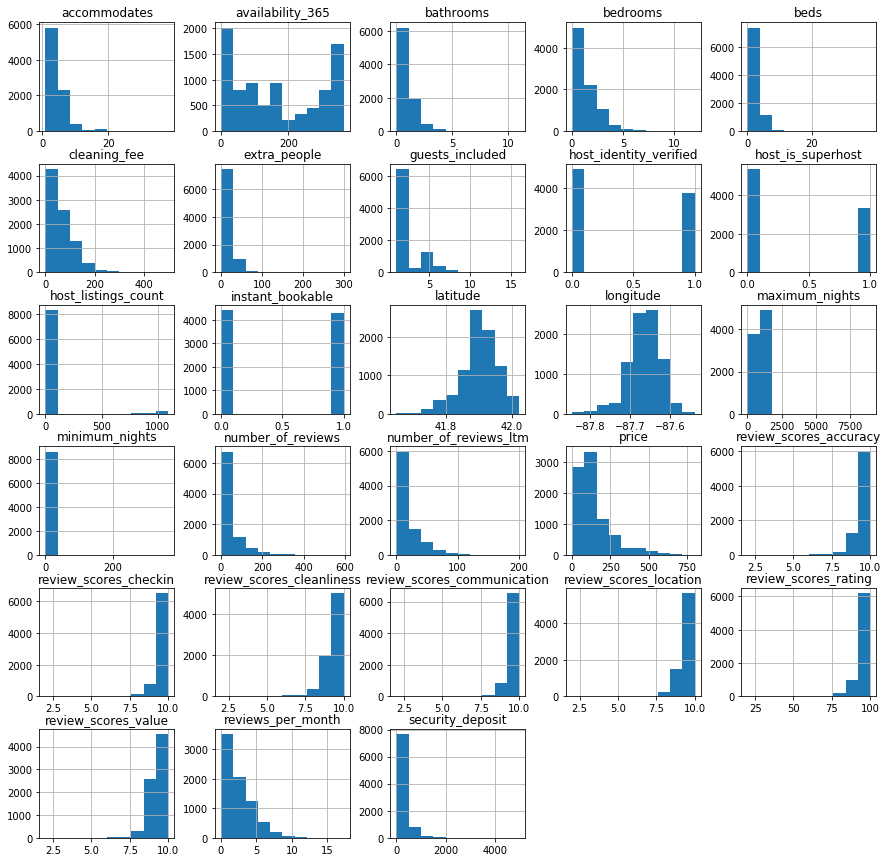

In [26]:
from pprint import pprint

test = air_df.columns.tolist()
pprint(test)

del pprint 

air_df.hist(figsize=(15,15));

In [27]:
for x in air_df:
    if air_df[x].isna().sum() > 0:
        print(f'{x}: {air_df[x].isna().sum()}')

bathrooms: 4
bedrooms: 3
beds: 1
review_scores_rating: 1138
review_scores_accuracy: 1138
review_scores_cleanliness: 1138
review_scores_checkin: 1139
review_scores_communication: 1140
review_scores_location: 1139
review_scores_value: 1139
reviews_per_month: 1065


In [28]:
air_df.fillna(0,inplace=True)
air_df.head(2)

,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,1,1,1,Hyde Park,41.78886,-87.58671,Condominium,Private room,1,1.0,1.0,1.0,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,0.0,20.0,1,0.0,2,91,330,170,38,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2.97
1,1,1,1,Little Village,41.85495,-87.69696,Apartment,Entire home/apt,7,1.0,3.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",117.0,0.0,35.0,2,25.0,2,60,348,383,22,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1,2.98


#  reviews in-depth to figure which to drop, maybe all

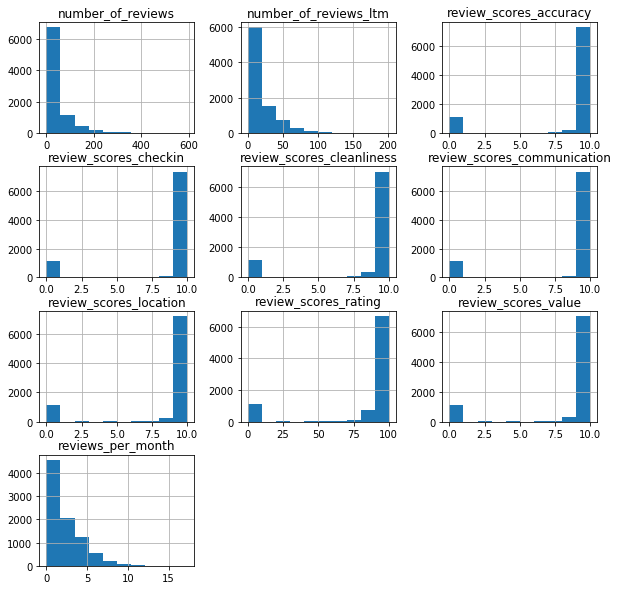

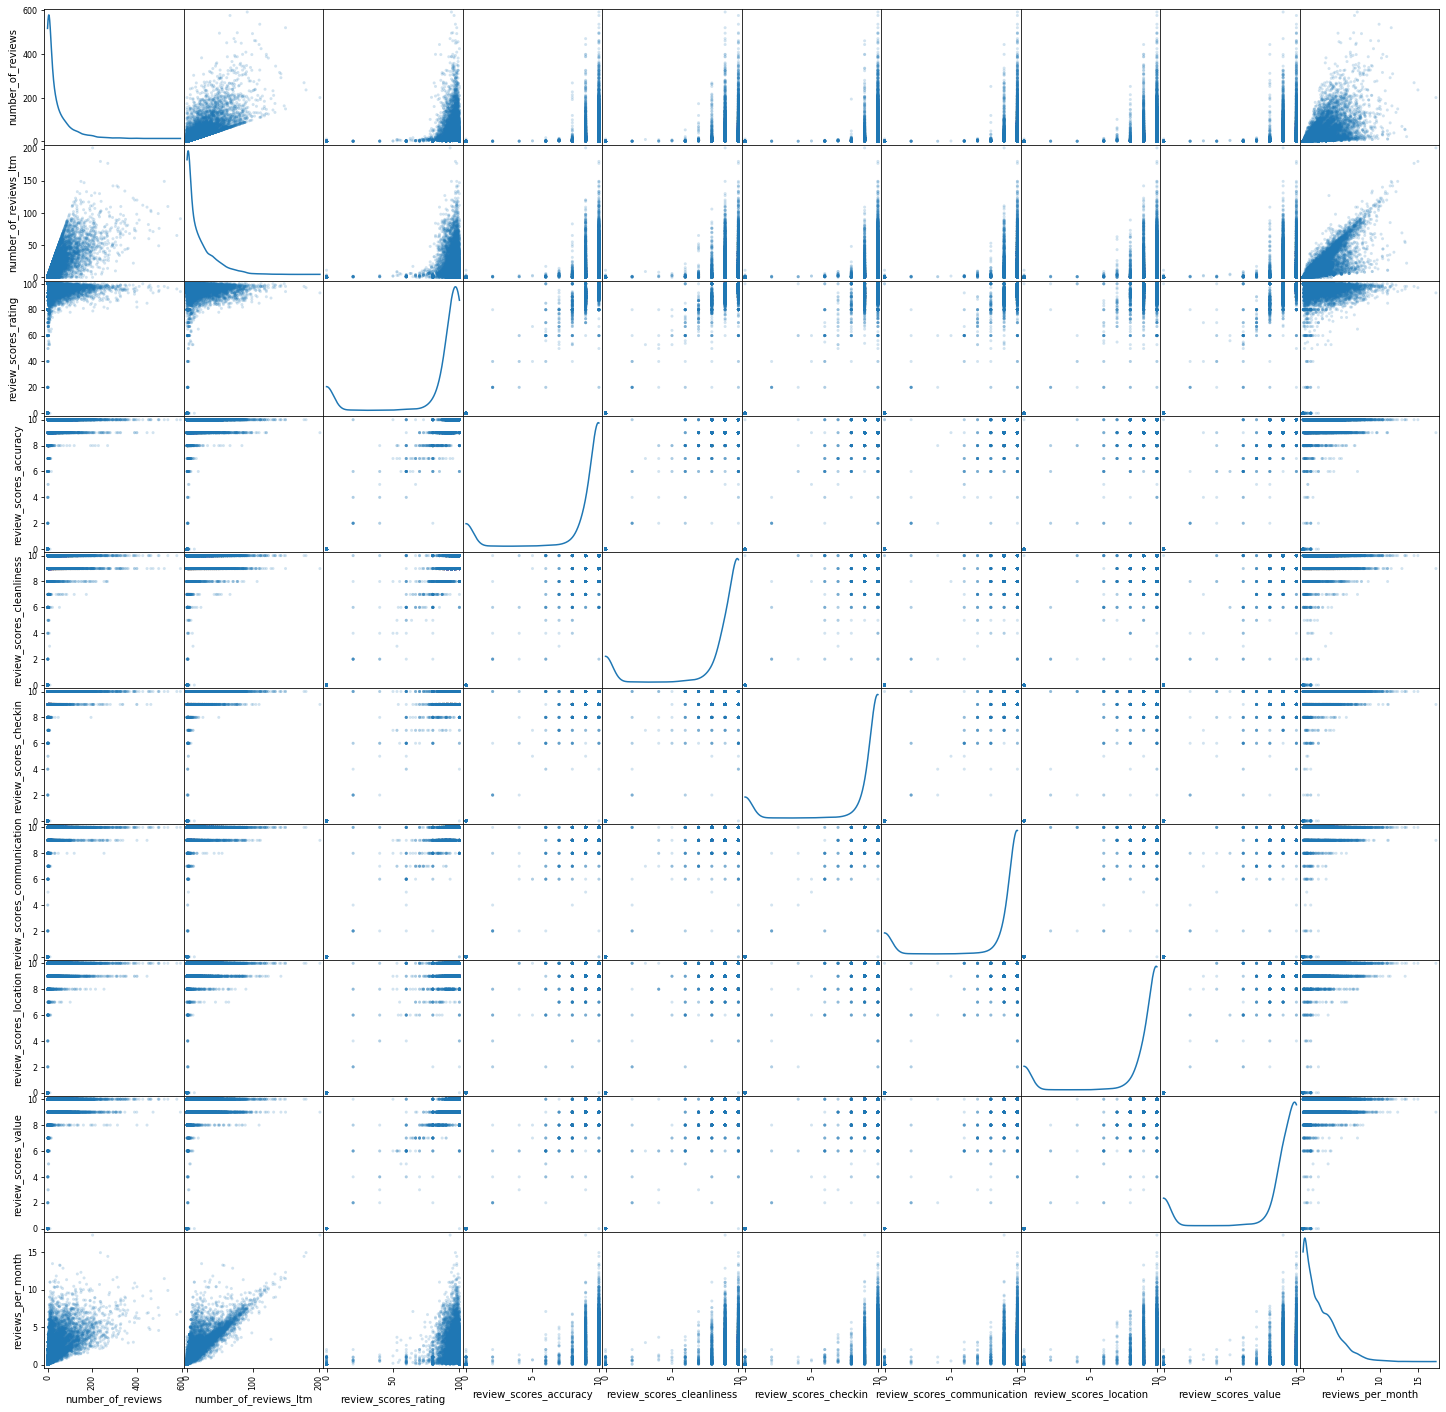

In [29]:
reviews_df = air_df[['number_of_reviews', 
                    'number_of_reviews_ltm', 
                    'review_scores_rating', 
                    'review_scores_accuracy', 
                    'review_scores_cleanliness', 
                    'review_scores_checkin', 
                    'review_scores_communication', 
                    'review_scores_location', 
                    'review_scores_value', 
                    'reviews_per_month'
                   ]]

reviews_df.hist(figsize=(10,10));
pd.plotting.scatter_matrix(reviews_df, alpha=0.2, figsize=(25, 25), diagonal='kde');

https://seaborn.pydata.org/generated/seaborn.heatmap.html<br/>
`
corr = np.corrcoef(np.random.randn(10, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)`

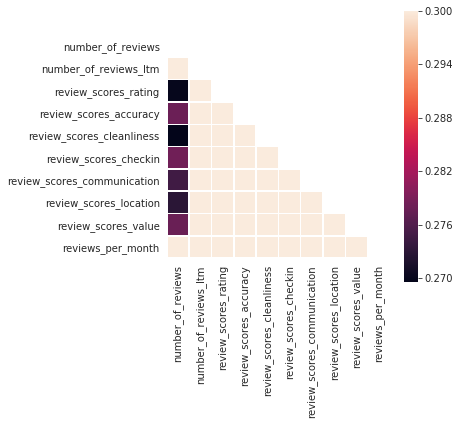

In [30]:
plt.figure(figsize=(5, 5))

corr = reviews_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, linewidths=.5)

In [31]:
# number_of_reviews
# review_scores_rating

temp = ['number_of_reviews_ltm', 
        'review_scores_accuracy', 
        'review_scores_cleanliness', 
        'review_scores_checkin', 
        'review_scores_communication', 
        'review_scores_location', 
        'review_scores_value', 
        'reviews_per_month'
       ]

air_df.drop(temp, axis=1, inplace=True)
del temp

air_df.head(2)

,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable
0,1,1,1,Hyde Park,41.78886,-87.58671,Condominium,Private room,1,1.0,1.0,1.0,"{TV,Wifi,Kitchen,Breakfast,""Free street parkin...",50.0,0.0,20.0,1,0.0,2,91,330,170,100.0,1
1,1,1,1,Little Village,41.85495,-87.69696,Apartment,Entire home/apt,7,1.0,3.0,4.0,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",117.0,0.0,35.0,2,25.0,2,60,348,383,96.0,1


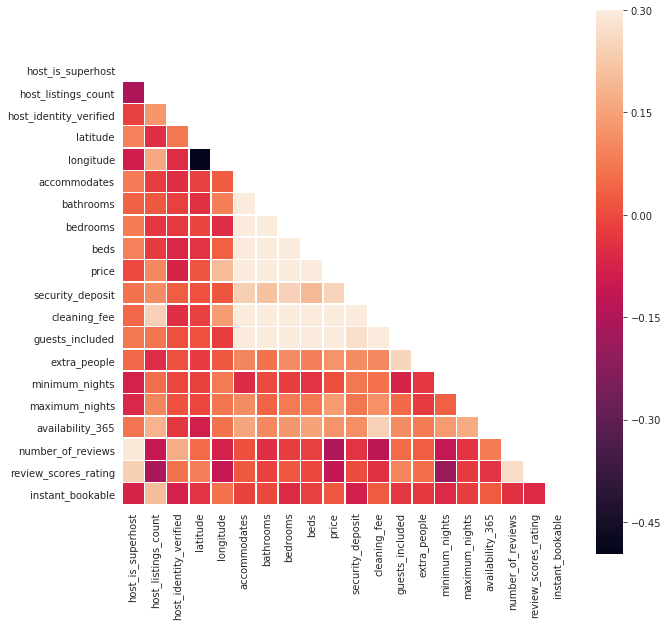

In [32]:
plt.figure(figsize=(10, 10))

corr = air_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, linewidths=.5)

# Reviewing Amenities (another day)

In [33]:
amenities_df = air_df['amenities'].copy

# :(

# XGBoost 
https://www.kaggle.com/mgabrielkerr/visualizing-knn-svm-and-xgboost-on-iris-dataset<br/><br/>
https://xgboost.readthedocs.io/en/latest/python/python_intro.html<br/>
https://www.kaggle.com/kobakhit/xgboost<br/>
https://www.kaggle.com/gayathrydasika/xgb-regressor-basic<br/>
https://www.datacamp.com/community/tutorials/xgboost-in-python<br/>
https://heartbeat.fritz.ai/boosting-your-machine-learning-models-using-xgboost-d2cabb3e948f<br/>
https://towardsdatascience.com/modeling-price-with-regularized-linear-model-xgboost-55e59eae4482<br/>
https://www.youtube.com/watch?v=yjZbTTdYmk0

In [34]:
air_df.drop('amenities', axis=1, inplace=True)

In [35]:
air_df.head(2)

,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable
0,1,1,1,Hyde Park,41.78886,-87.58671,Condominium,Private room,1,1.0,1.0,1.0,50.0,0.0,20.0,1,0.0,2,91,330,170,100.0,1
1,1,1,1,Little Village,41.85495,-87.69696,Apartment,Entire home/apt,7,1.0,3.0,4.0,117.0,0.0,35.0,2,25.0,2,60,348,383,96.0,1


In [36]:
air_dum_df = pd.get_dummies(air_df)

air_dum_df.head(2)

,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,instant_bookable,neighbourhood_Albany Park,neighbourhood_Andersonville,neighbourhood_Archer Heights,neighbourhood_Armour Square,neighbourhood_Ashburn,neighbourhood_Auburn Gresham,neighbourhood_Austin,neighbourhood_Avalon Park,neighbourhood_Avondale,neighbourhood_Back of the Yards,neighbourhood_Belmont Cragin,neighbourhood_Beverly,neighbourhood_Boystown,neighbourhood_Bridgeport,neighbourhood_Brighton Park,neighbourhood_Bronzeville,neighbourhood_Bucktown,neighbourhood_Calumet Heights,neighbourhood_Chatham,neighbourhood_Chinatown,neighbourhood_Clearing,neighbourhood_Dunning,neighbourhood_Edgewater,neighbourhood_Edison Park,neighbourhood_Englewood,neighbourhood_Gage Park,neighbourhood_Galewood,neighbourhood_Garfield Park,neighbourhood_Garfield Ridge,neighbourhood_Gold Coast,neighbourhood_Grand Crossing,neighbourhood_Hegewisch,neighbourhood_Hermosa,...,neighbourhood_Logan Square,neighbourhood_Loop,neighbourhood_Magnificent Mile,neighbourhood_Marquette Park,neighbourhood_McKinley Park,neighbourhood_Montclare,neighbourhood_Morgan Park,neighbourhood_Mt. Greenwood,neighbourhood_Near North Side,neighbourhood_Near West Side,neighbourhood_North Center,neighbourhood_North Lawndale,neighbourhood_North Park,neighbourhood_Norwood Park,neighbourhood_O'Hare,neighbourhood_Oakland,neighbourhood_Old Town,neighbourhood_Pilsen,neighbourhood_Portage Park,neighbourhood_Pullman,neighbourhood_River North,neighbourhood_River West,neighbourhood_Riverdale,neighbourhood_Rogers Park,neighbourhood_Roscoe Village,neighbourhood_Roseland,neighbourhood_Sauganash,neighbourhood_South Chicago,neighbourhood_South Deering,neighbourhood_South Loop/Printers Row,neighbourhood_South Shore,neighbourhood_Streeterville,neighbourhood_Ukrainian Village,neighbourhood_Uptown,neighbourhood_Washington Heights,neighbourhood_Washington Park,neighbourhood_West Elsdon,neighbourhood_West Lawn,neighbourhood_West Loop/Greektown,neighbourhood_West Pullman,neighbourhood_West Ridge,neighbourhood_West Town/Noble Square,neighbourhood_Wicker Park,neighbourhood_Woodlawn,neighbourhood_Wrigleyville,property_type_Apartment,property_type_Condominium,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,1,1,1,41.78886,-87.58671,1,1.0,1.0,1.0,50.0,0.0,20.0,1,0.0,2,91,330,170,100.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,1,1,41.85495,-87.69696,7,1.0,3.0,4.0,117.0,0.0,35.0,2,25.0,2,60,348,383,96.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

X = air_dum_df.drop('price', axis=1)
y = air_dum_df.price

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
print(f'Train Shape: {X_train.shape[0]:,}\nTest Shape: { X_test.shape[0]:,}')

Train Shape: 6,953
Test Shape: 1,739


In [40]:
import warnings
warnings.filterwarnings('ignore')

xgb_clf = xgb.XGBRegressor()
xgb_clf.fit(X_train, y_train)
xgb_preds = xgb_clf.predict(X_train)
xgb_tests = xgb_clf.predict(X_test)

print(f'\nTrain MSE: {mean_squared_error(y_train, xgb_preds):,.2f}')
print(f'Test MSE: {mean_squared_error(y_test, xgb_tests):,.2f}')

print(f'\nTrain Accuracy/R2: {xgb_clf.score(X_train, y_train):.1%}')
print(f'Test Accuracy/R2: {xgb_clf.score(X_test, y_test):.1%}')

[03:59:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Train MSE: 4,323.18
Test MSE: 4,854.53

Train Accuracy/R2: 68.8%
Test Accuracy/R2: 65.8%


OrderedDict([('latitude', 73),
             ('cleaning_fee', 68),
             ('longitude', 66),
             ('accommodates', 64),
             ('host_listings_count', 53),
             ('availability_365', 45),
             ('bedrooms', 37),
             ('extra_people', 33),
             ('minimum_nights', 29),
             ('number_of_reviews', 28),
             ('bathrooms', 22),
             ('security_deposit', 20),
             ('beds', 16),
             ('guests_included', 16),
             ('review_scores_rating', 14),
             ('room_type_Hotel room', 12),
             ('maximum_nights', 12),
             ('neighbourhood_River North', 10),
             ('neighbourhood_South Loop/Printers Row', 9),
             ('room_type_Shared room', 9),
             ('neighbourhood_Lakeview', 8),
             ('room_type_Entire home/apt', 5),
             ('neighbourhood_West Loop/Greektown', 5),
             ('host_is_superhost', 5),
             ('room_type_Private room', 4),
     

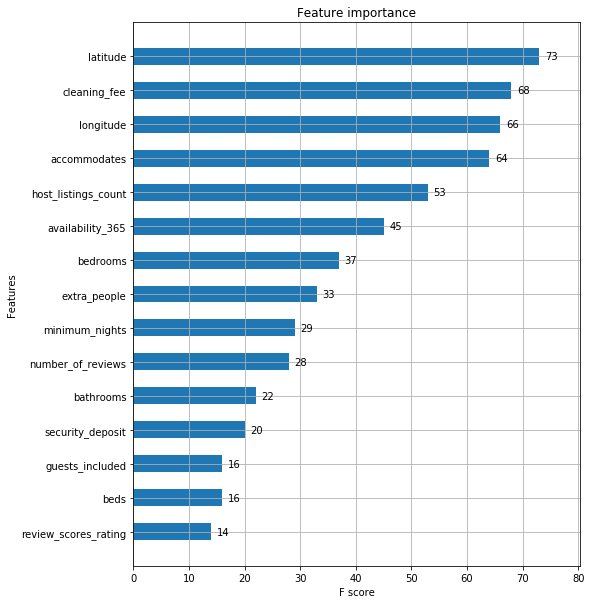

In [41]:
from collections import OrderedDict
# xgb_clf.get_booster().get_score(importance_type='weight')

fig, ax = plt.subplots(figsize = (8, 10))
xgb.plot_importance(xgb_clf, max_num_features = 15, height = .5, ax = ax);

OrderedDict(sorted(xgb_clf.get_booster().get_fscore().items(), key=lambda x: x[1], reverse=True))

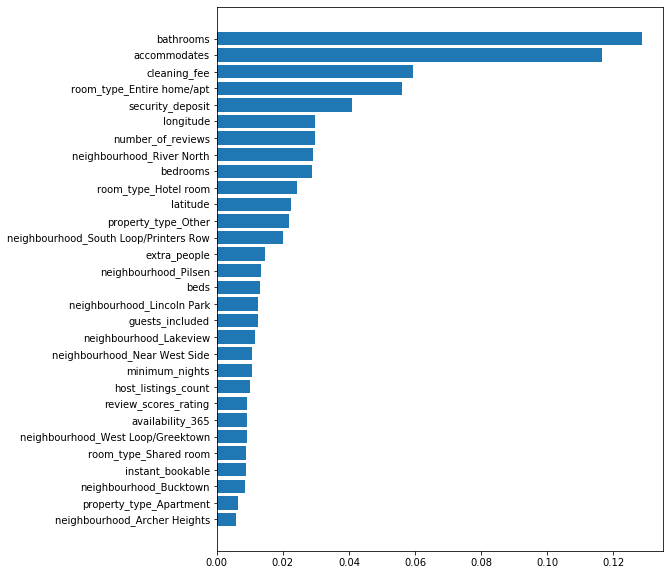

In [42]:
temp = pd.DataFrame(xgb_clf.feature_importances_, columns=['weight'], index = X_train.columns)
temp.sort_values('weight', inplace=True)

# plotting top 30
temp = temp.iloc[84:-1]

plt.figure(figsize=(8,10))
plt.barh(temp.index, temp.weight) 

del temp
plt.show()

# KNN

### KNN Method # 1

In [ ]:
y = temp['price']
X = temp.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) 

In [ ]:
train_scores = []
test_scores = []

for k in range(1, 100, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
plt.plot(range(1, 100, 2), train_scores, marker='o', label='Train')
plt.plot(range(1, 100, 2), test_scores, marker="x", label='Test')
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.legend()
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=93)
knn.fit(X_train, y_train)
print('k=93 Test Acc: %.3f' % knn.score(X_test, y_test))

### KNN Regressor

In [ ]:
len(y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

train_df = temp.iloc[0:2213]
test_df = temp.iloc[2213:]

train_columns = ['accommodates']

knn = KNeighborsRegressor(n_neighbors=93, algorithm='auto')
# knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

features = train_df.columns.tolist()
features.remove('price')
knn.fit(train_df[features], train_df['price'])

all_features_predictions = knn.predict(test_df[features])
all_features_mse = mean_squared_error(test_df['price'], all_features_predictions)
all_features_rmse = all_features_mse ** (1/2)

print(f'MSE: ${all_features_mse:,.2f}')
print(f'RMSE: ${all_features_rmse:,.2f}')